In [1]:
# ----------------------------
# Clone your repo
# ----------------------------
!git clone https://github.com/quantivly/rsna-deep-learning-lab-2025.git
%cd rsna-deep-learning-lab-2025

# ----------------------------
# Downgrade numpy/scipy to avoid import errors
# ----------------------------
!pip install --force-reinstall numpy==1.26.4 scipy==1.10.1

# ----------------------------
# Install PyTorch 2.3.0 + CUDA 12.1
# ----------------------------
!pip install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# ----------------------------
# Install PyG 2.6.1 + extensions (Python 3.12 compatible)
# ----------------------------
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
  -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

!pip install torch_geometric==2.6.1


Cloning into 'rsna-deep-learning-lab-2025'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 41 (delta 16), reused 37 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 101.56 KiB | 3.50 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/rsna-deep-learning-lab-2025
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Pyth

In [2]:
#Make sure you have the latest
%cd /content/rsna-deep-learning-lab-2025
!git pull

/content/rsna-deep-learning-lab-2025
Already up to date.


### Data Preprocessing and the DataCollection Class

**Why StandardScaler, OneHotEncoder, and ColumnTransformer?**

- **StandardScaler:** Normalizes numerical features to have mean 0 and variance 1
  - Helps the model learn efficiently, prevents domination by large-magnitude features
- **OneHotEncoder:** Converts categorical features into a binary vector representation
  - Allows the model to process non-numeric features without imposing arbitrary order
- **ColumnTransformer:** Combines multiple preprocessing steps for different feature types
  - Ensures numeric and categorical columns are processed appropriately in one pipeline

**Goal of `DataCollection` class:**

- Organizes **multi-modal patient data** from multiple sources:
  - Clinical metadata
  - Radiomic features
  - Gene assays
- Maps all patients, radiomic nodes, and gene nodes to **unique indices** for graph construction
- Builds **edges between patients and their corresponding radiomic/gene nodes**

**What will the raw features be used for?**

- Serve as **initial node features** for the heterogeneous graph
  - `patient` nodes: metadata features
  - `radiomic` nodes: extracted radiomic features
  - `gene` nodes: assay measurements
- Allow the GNN to **aggregate multi-modal information** to produce meaningful patient embeddings

**Why this logic is important:**

- Ensures consistent **node indexing** and **feature scaling**
- Sets up the graph so that downstream GNN operations (e.g., `HeteroConv`) can **correctly combine information across node types**
- Makes the graph **ready for contrastive learning and embedding generation**

```python
class DataCollection:
    """Class for loading and processing clinical metadata, radiomic features, and gene assay data."""
    def __init__(self, metadata_path: str, radiomic_path: str, gene_assay_path: str):
        self.metadata = pd.read_csv(metadata_path)
        self.radiomic = pd.read_csv(radiomic_path)
        self.gene_assay = pd.read_csv(gene_assay_path)
        self.set_radiomic_ids # set patient_id in radiomic dataframe so that it can be matched
        self.unique_ids = self.unique_patient_ids
    
    @property
    def set_radiomic_ids(self):
        ids = ['-'.join(n.split('.')[0].split('-')[:3]) for n in self.radiomic['Lesion Name'].to_list()]
        self.radiomic['patient_id'] = ids

    @property
    def unique_patient_ids(self):
        all_patient_ids = sorted(set(self.metadata['bcr_patient_barcode'].to_list())
                                 | set(self.radiomic['patient_id'].to_list())
                                 | set(self.gene_assay['CLID'].to_list()))
        return all_patient_ids
    
    @property
    def patient_node_mapping(self):
        patient_ids = self.unique_patient_ids
        mapping = {pid: idx for idx, pid in enumerate(patient_ids)}
        return mapping
    
    @property
    def radiomic_node_mapping(self):
        return {i: idx for i, idx in enumerate(self.radiomic.index)}
    
    @property
    def gene_assay_node_mapping(self):
        return {i: idx for i, idx in enumerate(self.gene_assay.index)}
    
    @property
    def build_radiomic_to_patient_edges(self):
        src_nodes = list(self.radiomic_node_mapping.values())
        dst_nodes = [self.patient_node_mapping[pid] for pid in self.radiomic['patient_id'].to_list()]
        return (src_nodes, dst_nodes)
    
    @property
    def build_gene_assay_to_patient_edges(self):
        src_nodes = list(self.gene_assay_node_mapping.values())
        dst_nodes = [self.patient_node_mapping[pid] for pid in self.gene_assay['CLID'].to_list()]
        return (src_nodes, dst_nodes)
    
    def get_radiomic_features(self, columns_to_drop: list=['Lesion Name', 'patient_id']):
        features = self.radiomic.drop(columns=columns_to_drop, errors='ignore')
        scaler = StandardScaler()
        return scaler.fit_transform(features.values)
    
    def get_gene_assay_features(self, columns_to_drop: list=['CLID', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']):
        feature_cols = [c for c in self.metadata.columns if c not in columns_to_drop]
        numeric_cols = self.metadata[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = list(set(feature_cols) - set(numeric_cols))
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
            ]
        )
        return preprocessor.fit_transform(self.metadata[feature_cols])
    
    def get_patient_metadata_features(self, columns_to_drop: list=['bcr_patient_barcode', 'patient_id']):
        feature_cols = [c for c in self.metadata.columns if c not in columns_to_drop]
        numeric_cols = self.metadata[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = list(set(feature_cols) - set(numeric_cols))
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
            ]
        )
        return preprocessor.fit_transform(self.metadata[feature_cols])
```

### Patient Representation GNN: Heterogeneous Graph Neural Network

**Purpose of this model:**

- Learn **low-dimensional patient embeddings** by aggregating information from:
  - `radiomic` nodes (image-derived features)
  - `gene` nodes (multi-gene assay features)
  - Other `patient` nodes via similarity edges
- It's important to note that due to the Graph Topology we've defined, the produced embedding are only focused on MERGING multi-modal information.

**Key Components:**

1. **HeteroConv**
   - Handles **multiple edge types** in a heterogeneous graph
   - Aggregates messages **from different node types separately**, then sums them
   - In our model:
     - `radiomic -> patient`
     - `gene -> patient`
     - `patient -> patient` (similarity edges)

2. **GATConv (Graph Attention Convolution)**
   - Assigns **learned attention weights** to neighbors
   - Helps model **focus on more relevant neighbors** when aggregating features

3. **Linear Layer**
   - Reduces aggregated hidden features to **final embedding size**
   - Produces **patient embedding vector** that captures multi-modal information

**Forward pass overview:**

- Each node type sends messages along its edges
- Messages are **weighted and aggregated** for each destination node
- Aggregated features pass through **ReLU activation**
- Patient node features are projected through a **linear layer** to produce embeddings

**Why this design matters:**

- Allows **integration of heterogeneous data** while preserving node-type structure
- Produces embeddings that reflect **multi-modal patient information**
- Can be used for **downstream tasks** like similarity comparison, clustering, or predictive modeling

```python
class PatientRepresentationGNN(nn.Module):
    def __init__(self, data, hidden_dim=64, out_dim=32):
        super().__init__()

        # --- Infer feature dims from graph ---
        patient_in = data['patient'].x.size(1)
        radiomic_in = data['radiomic'].x.size(1)
        gene_in = data['gene'].x.size(1)

        # --- Build HeteroConv with correct per-edge dims ---
        self.conv1 = HeteroConv({
            ('radiomic', 'to', 'patient'):
                GATConv((radiomic_in, patient_in), hidden_dim, add_self_loops=False),

            ('gene', 'to', 'patient'):
                GATConv((gene_in, patient_in), hidden_dim, add_self_loops=False),

            ('patient', 'similar', 'patient'):
                GATConv((patient_in, patient_in), hidden_dim, add_self_loops=False),
        }, aggr='sum')

        self.lin = nn.Linear(hidden_dim, out_dim)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: torch.relu(v) for k, v in x_dict.items()}
        x_dict['patient'] = self.lin(x_dict['patient'])
        return x_dict
```

In [9]:
#Use this cell if you need to navigate to content folder
%cd rsna_deep_learning_lab_2025

/content/rsna-deep-learning-lab-2025/rsna_deep_learning_lab_2025


In [10]:
from rsna_deep_learning_lab_2025.train import load_data, Trainer, load_model_and_optimizer

#Use this cell if you need to navigate to content folder to initilize the variables
%cd rsna_deep_learning_lab_2025
dataset = load_data()
model, optimizer = load_model_and_optimizer(dataset['data'])

#Train model using pre-defined functions
trainer = Trainer(model, optimizer, dataset)

losses = trainer.train(500, verbose=False)



/usr/local/lib/python3.12/dist-packages/torch_geometric/nn/conv/hetero_conv.py:76: UserWarning: There exist node types ({'gene', 'radiomic'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(


Training complete.


In [11]:
import pandas as pd

df = pd.DataFrame({'losses': losses, 'model_name': ['model']*len(losses)})
for hidden_, out_, name in [[128, 64, 'model_1'], [256, 128, 'model_2']]:
  model, optimizer = load_model_and_optimizer(dataset['data'], hidden_, out_)

  #Train model using pre-defined functions
  trainer = Trainer(model, optimizer, dataset)

  losses = trainer.train(500, verbose=False)
  df = pd.concat([df, pd.DataFrame({'losses': losses, 'model_name': [name]*len(losses)})])

Training complete.
Training complete.


In [12]:
import plotly.express as px
px.line(df, y='losses', color='model_name')

In [13]:
from rsna_deep_learning_lab_2025.utils import DataViewer

viewer = DataViewer(dataset['data'], dataset['data_collection'])

In [14]:
#Fetch associated embeddings and genetic info
patient_embeddings = trainer.get_patient_embeddings
gene_info = viewer.fetch_connected_gene_features

In [15]:
#Get only relevant patient info
raw_patient_features = viewer.fetch_all_patient_features[gene_info['patient_idx_with_genes']]
patient_embeddings_filtered = patient_embeddings[gene_info['patient_idx_with_genes']]

#Get similarity matrix
sim_P = viewer.fetch_cosine_similarity(raw_patient_features)
sim_G = viewer.fetch_cosine_similarity(gene_info['G']) #'G' is the graph associated with genetic raw features
sim_E = viewer.fetch_cosine_similarity(patient_embeddings_filtered)

In [16]:
import pandas as pd
import numpy as np
import torch
import plotly.express as px
import pandas as pd
from scipy.stats import pearsonr, spearmanr

def flatten_pairwise(simA, simB):
      mask = ~np.eye(simA.shape[0], dtype=bool)
      return simA[mask], simB[mask]

x_gene, y_raw = flatten_pairwise(sim_G, sim_P)
_, y_emb = flatten_pairwise(sim_G, sim_E)

# Combine data into a single DataFrame with a 'type' column
df_combined = pd.DataFrame({
    "gene_sim": list(x_gene) * 2,
    "patient_sim": list(y_raw) + list(y_emb),
    "type": ["Raw"] * len(x_gene) + ["Embedding"] * len(x_gene)
})

fig = px.scatter(
    df_combined,
    x="gene_sim",
    y="patient_sim",
    color="type",
    trendline="ols",
    title="Patient Features vs Gene Similarity (Raw & Embedding)"
)
fig.show()



In [17]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Separate the groups
raw_df = df_combined[df_combined["type"] == "Raw"]
emb_df = df_combined[df_combined["type"] == "Embedding"]

# Pearson correlation
r_raw, p_raw = pearsonr(raw_df["gene_sim"], raw_df["patient_sim"])
r_emb, p_emb = pearsonr(emb_df["gene_sim"], emb_df["patient_sim"])

print(f"Raw correlation: r={r_raw:.3f}, p={p_raw:.3g}")
print(f"Embedding correlation: r={r_emb:.3f}, p={p_emb:.3g}")

#You can use Fisher’s r-to-z transformation to statistically compare two correlation coefficients
def fisher_r_to_z(r):
    return 0.5 * np.log((1+r)/(1-r))

z_raw = fisher_r_to_z(r_raw)
z_emb = fisher_r_to_z(r_emb)
n_raw = len(raw_df)
n_emb = len(emb_df)

# z-score for difference
z_diff = (z_emb - z_raw) / np.sqrt(1/(n_raw-3) + 1/(n_emb-3))
from scipy.stats import norm
p_value = 2 * (1 - norm.cdf(abs(z_diff)))

print(f"Z-test for difference in correlations: z={z_diff:.3f}, p={p_value:.3g}")


Raw correlation: r=0.041, p=4.44e-05
Embedding correlation: r=0.232, p=3.62e-121
Z-test for difference in correlations: z=13.740, p=0


In [18]:
# Convert cosine similarity to distances
dist_P = 1 - sim_P
sim_E_normalized = (sim_E + 1) / 2  # now 0 → 1
dist_E = 1 - sim_E_normalized
dist_G = 1 - sim_G

threshold_far = 0.75   # top 25% far
threshold_close = 0.25  # bottom 25% close

# Mask for far in raw, close in gene
mask_far_raw_close_gene = (dist_P > np.quantile(dist_P, threshold_far)) & \
                          (dist_G < np.quantile(dist_G, threshold_close))

# Mask for close in raw, far in gene
mask_close_raw_far_gene = (dist_P < np.quantile(dist_P, threshold_close)) & \
                          (dist_G > np.quantile(dist_G, threshold_far))
# distances in embedding space
dist_E_flat = dist_E[np.triu_indices_from(dist_E, k=1)]  # take upper triangle
dist_P_flat = dist_P[np.triu_indices_from(dist_P, k=1)]
dist_G_flat = dist_G[np.triu_indices_from(dist_G, k=1)]

# masks flattened
mask_far_raw_close_gene_flat = mask_far_raw_close_gene[np.triu_indices_from(dist_P, k=1)]
mask_close_raw_far_gene_flat = mask_close_raw_far_gene[np.triu_indices_from(dist_P, k=1)]

# Calculate mean changes
mean_before_far_raw = dist_P_flat[mask_far_raw_close_gene_flat].mean()
mean_after_far_raw = dist_E_flat[mask_far_raw_close_gene_flat].mean()
print("Pairs far in raw but close in gene:")
print("Mean distance before:", mean_before_far_raw)
print("Mean distance after (embedding):", mean_after_far_raw)

mean_before_close_raw = dist_P_flat[mask_close_raw_far_gene_flat].mean()
mean_after_close_raw = dist_E_flat[mask_close_raw_far_gene_flat].mean()
print("Pairs close in raw but far in gene:")
print("Mean distance before:", mean_before_close_raw)
print("Mean distance after (embedding):", mean_after_close_raw)


Pairs far in raw but close in gene:
Mean distance before: 0.69563806
Mean distance after (embedding): 0.46428183
Pairs close in raw but far in gene:
Mean distance before: 0.39162993
Mean distance after (embedding): 0.49587572


In [19]:
from scipy.stats import ttest_rel
import numpy as np

def print_pairwise_distance_stats(before, after, pair_type):
    mean_before = np.mean(before)
    mean_after = np.mean(after)
    mean_change = mean_after - mean_before
    ttest = ttest_rel(before, after)

    direction = "decreased" if mean_change < 0 else "increased"

    print(f"--- {pair_type} ---")
    print(f"Mean distance before embedding: {mean_before:.3f}")
    print(f"Mean distance after embedding:  {mean_after:.3f}")
    print(f"Mean change: {mean_change:.3f} ({direction})")
    print(f"Paired t-test: t={ttest.statistic:.3f}, p={ttest.pvalue:.3g}")

    if ttest.pvalue < 0.05:
        print(f"Result: The change is statistically significant (p < 0.05).")
    else:
        print(f"Result: The change is not statistically significant (p ≥ 0.05).")
    print("\n")

# Far in raw but close in gene (should decrease)
print_pairwise_distance_stats(
    dist_P_flat[mask_far_raw_close_gene_flat],
    dist_E_flat[mask_far_raw_close_gene_flat],
    "Pairs far in raw but close in gene"
)

# Close in raw but far in gene (should increase)
print_pairwise_distance_stats(
    dist_P_flat[mask_close_raw_far_gene_flat],
    dist_E_flat[mask_close_raw_far_gene_flat],
    "Pairs close in raw but far in gene"
)

--- Pairs far in raw but close in gene ---
Mean distance before embedding: 0.696
Mean distance after embedding:  0.464
Mean change: -0.231 (decreased)
Paired t-test: t=43.400, p=5.42e-134
Result: The change is statistically significant (p < 0.05).


--- Pairs close in raw but far in gene ---
Mean distance before embedding: 0.392
Mean distance after embedding:  0.496
Mean change: 0.104 (increased)
Paired t-test: t=-20.081, p=3.75e-55
Result: The change is statistically significant (p < 0.05).




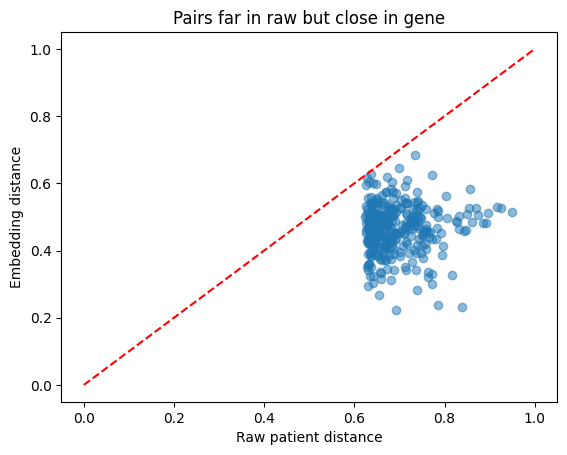

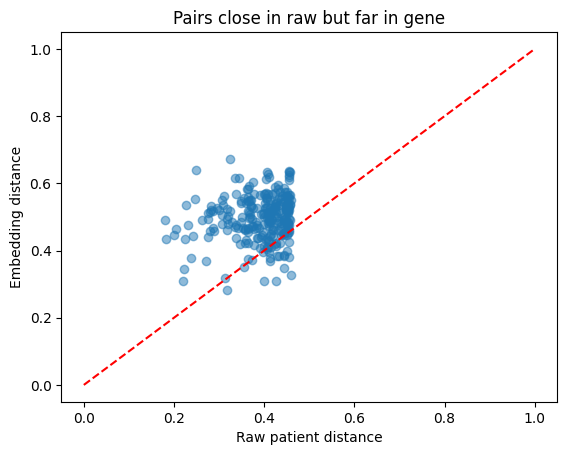

In [20]:
import matplotlib.pyplot as plt

# Far raw, close gene
plt.scatter(dist_P_flat[mask_far_raw_close_gene_flat],
            dist_E_flat[mask_far_raw_close_gene_flat],
            alpha=0.5)
plt.xlabel("Raw patient distance")
plt.ylabel("Embedding distance")
plt.title("Pairs far in raw but close in gene")
plt.plot([0,1],[0,1], 'r--')  # y=x reference
plt.show()

# Close raw, far gene
plt.scatter(dist_P_flat[mask_close_raw_far_gene_flat],
            dist_E_flat[mask_close_raw_far_gene_flat],
            alpha=0.5)
plt.xlabel("Raw patient distance")
plt.ylabel("Embedding distance")
plt.title("Pairs close in raw but far in gene")
plt.plot([0,1],[0,1], 'r--')  # y=x reference
plt.show()

In [21]:

K = 10
N = sim_E.shape[0]

# Compute top-K neighbors in each space
topk_E = np.argsort(-sim_E, axis=1)[:, 1:K+1]   # exclude self
topk_G = np.argsort(-sim_G, axis=1)[:, 1:K+1]
topk_P = np.argsort(-sim_P, axis=1)[:, 1:K+1]

# Compute overlap
overlaps_meta = []
for p in range(N):
  overlap = len(set(topk_P[p]).intersection(topk_G[p])) / K
  overlaps_meta.append(overlap)

overlaps_embedding = []
for p in range(N):
  overlap = len(set(topk_E[p]).intersection(topk_G[p])) / K
  overlaps_embedding.append(overlap)

#Combine overlaps and convert to DataFrame
overlaps = [[o,c] for el, c in [[overlaps_embedding, 'embedding'], [overlaps_meta, 'metadata_raw']] for o in el]
df = pd.DataFrame(overlaps, columns=['data', 'group'])

px.histogram(df, x='data', color='group', nbins=20, title=f"Top-{K} Neighbor Overlap Between Group and Gene Space", labels={"value": "Neighbor Overlap (%)"}, barmode='group', marginal='box')

In [23]:
!pip install faiss-cpu
import faiss

#Construct similarity search index from embeddings
array = patient_embeddings_filtered.cpu().numpy()
index = faiss.IndexFlatIP(array.shape[1])
faiss.normalize_L2(array)
index.add(array)
D, I = index.search(array, 10)

#Find example of highest neighbor pair
src, target = I[D[:,1].argmax(), 1], D[:,1].argmax()
src_patient_id, tagert_patient_id = gene_info['patient_idx_with_genes'][src], gene_info['patient_idx_with_genes'][target]
src_referrence_id, target_referrence_id = dataset['data_collection'].unique_patient_ids[src_patient_id], dataset['data_collection'].unique_patient_ids[tagert_patient_id]

#Look at similarity evolution
print(sim_G[src,target], sim_E[src,target], sim_P[src,target])


0.45734608 0.69472694 0.4042511


In [24]:
#Look at raw features
dataset['data_collection'].metadata.query("bcr_patient_barcode == @src_referrence_id")


,bcr_patient_barcode,age_at_initial_pathologic_diagnosis,ajcc_cancer_metastasis_stage_code,ajcc_neoplasm_disease_lymph_node_stage,ajcc_neoplasm_disease_stage,ajcc_tumor_stage_code,anatomic_organ_subdivision,axillary_lymph_node_stage_method_type,breast_cancer_optical_measurement_histologic_type,breast_cancer_surgery_margin_status,...,lymph_node_examined_count,margin_status,menopause_status,number_of_lymphnodes_positive_by_he,patient_id,pretreatment_history,prior_diagnosis,race,tissue_source_site,vital_status
90,TCGA-BH-A0E0,38,M0,N3a,Stage IIIC,T3,Left Upper Outer Quadrant|Left Lower Outer Qua...,Axillary lymph node dissection alone,Infiltrating Ductal,[Not Available],...,21,Negative,Pre (<6 months since LMP AND no prior bilatera...,10,A0E0,NO,NO,WHITE,BH,LIVING


In [25]:
#Look at raw features
dataset['data_collection'].metadata.query("bcr_patient_barcode == @target_referrence_id")


,bcr_patient_barcode,age_at_initial_pathologic_diagnosis,ajcc_cancer_metastasis_stage_code,ajcc_neoplasm_disease_lymph_node_stage,ajcc_neoplasm_disease_stage,ajcc_tumor_stage_code,anatomic_organ_subdivision,axillary_lymph_node_stage_method_type,breast_cancer_optical_measurement_histologic_type,breast_cancer_surgery_margin_status,...,lymph_node_examined_count,margin_status,menopause_status,number_of_lymphnodes_positive_by_he,patient_id,pretreatment_history,prior_diagnosis,race,tissue_source_site,vital_status
131,TCGA-AO-A12F,36,M0,N0 (i-),Stage IIA,T2,Right Upper Outer Quadrant|Right,Sentinel node biopsy alone,Infiltrating Ductal,[Not Available],...,17,Negative,Pre (<6 months since LMP AND no prior bilatera...,0,A12F,NO,NO,WHITE,AO,LIVING


In [26]:
#Look at gene features
dataset['data_collection'].gene_assay.query("CLID == @src_referrence_id")

,CLID,Pam50.Call,ROR-S Group (Subtype Only),ROR-P Group (Subtype + Proliferation),GHI_RS_3Group,GHI_RS Score,Mammaprint Predict.type,Mammaprint Pcorr_NKI70_Good_Correlation_Nature.2002_PMID.11823860,UNC_Scorr_Basal_Correlation_JCO.2009_PMID.19204204,UNC_Scorr_Her2_Correlation_JCO.2009_PMID.19204204,UNC_Scorr_LumA_Correlation_JCO.2009_PMID.19204204,UNC_Scorr_LumB_Correlation_JCO.2009_PMID.19204204,UNC_Scorr_Norm_Correlation_JCO.2009_PMID.19204204,UNC_ROR_S_Model_JCO.2009_PMID.19204204,UNC_Proliferation_11_Mean_JCO.2009_PMID.19204204,ROR-P (Subtype + Proliferation),Unnamed: 16,Unnamed: 17,Unnamed: 18
45,TCGA-BH-A0E0,Basal,high,high,High,100.0,NKI70_Bad,-0.586,0.488927,0.034629,-0.543639,-0.044399,-0.112679,65.899481,0.631386,72.377722,NaN,NaN,NaN


In [28]:
#Look at gene features
dataset['data_collection'].gene_assay.query("CLID == @target_referrence_id")

,CLID,Pam50.Call,ROR-S Group (Subtype Only),ROR-P Group (Subtype + Proliferation),GHI_RS_3Group,GHI_RS Score,Mammaprint Predict.type,Mammaprint Pcorr_NKI70_Good_Correlation_Nature.2002_PMID.11823860,UNC_Scorr_Basal_Correlation_JCO.2009_PMID.19204204,UNC_Scorr_Her2_Correlation_JCO.2009_PMID.19204204,UNC_Scorr_LumA_Correlation_JCO.2009_PMID.19204204,UNC_Scorr_LumB_Correlation_JCO.2009_PMID.19204204,UNC_Scorr_Norm_Correlation_JCO.2009_PMID.19204204,UNC_ROR_S_Model_JCO.2009_PMID.19204204,UNC_Proliferation_11_Mean_JCO.2009_PMID.19204204,ROR-P (Subtype + Proliferation),Unnamed: 16,Unnamed: 17,Unnamed: 18
11,TCGA-AO-A12F,Basal,high,med,High,100.0,NKI70_Bad,-0.501,0.747612,-0.200282,-0.496309,-0.289188,0.195289,57.680123,0.229269,52.470917,NaN,NaN,NaN
